# 模型性能分析
* 罗翊杰 
* 1951578@tongji.edu.cn
* MERCI Project
* 2023/5/15

## 1.读取数据

In [2]:
# 读取csv
import csv
data = []
with open('../Data/squ2011_88.csv','rt') as f:
    csv_reader = csv.reader(f)
    isHeader = True                 # 判断帧头
    for row in csv_reader:          # 将csv 文件中的数据保存到data中
        if isHeader:
            isHeader = False
            continue
        frame = {
            'time':row[0],
            'xyd':row[1:4],
            'press':row[4],
            'mag4':row[5:17]
            }
        data.append(frame)           # 将字典加入到data数组中
print("read csv file successfully")

read csv file successfully


In [3]:
# 获取原始数据
import numpy as np

length = len(data)
# 获取磁场数据，触点水平位置数据和压力数据
magnetic = []
position = []
press = []
for i,frame in enumerate(data):
    if(True):
        press.append(float(frame['press']))
        m = list(map(float, frame['mag4']))
        mm = [0,0,0,0,0,0,0,0,0,0,0,0]
        for k in range(3):
            for r in range(4):
                mm[r*3+k] = 2*m[k+r*3] - m[(k+1+r*3)%12] - m[k-1+r*3]
        magnetic.append(mm)
        position.append(list(map(float, frame['xyd'][:2])))

press = np.array(press)
magnetic = np.array(magnetic)
position = np.array(position)

In [4]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler
# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()
# 对触点位置与磁场数据进行 fit_transform 操作
normalized_magnetic = scaler.fit_transform(magnetic)

normalized_position = scaler.fit_transform(position)
normalized_press = (press - np.min(press))/(np.max(press) - np.min(press))
print(np.max(press) - np.min(press))

1.5065530475898339


## 2.载入模型

In [5]:
import keras
model = keras.models.load_model("./cnn_server/stm32.h5")

eloss,emae = model.evaluate(normalized_magnetic, position)
predict = model.predict(normalized_magnetic)

1135/1135 [==============================] - 1s 1ms/step


## 3.绘图部分

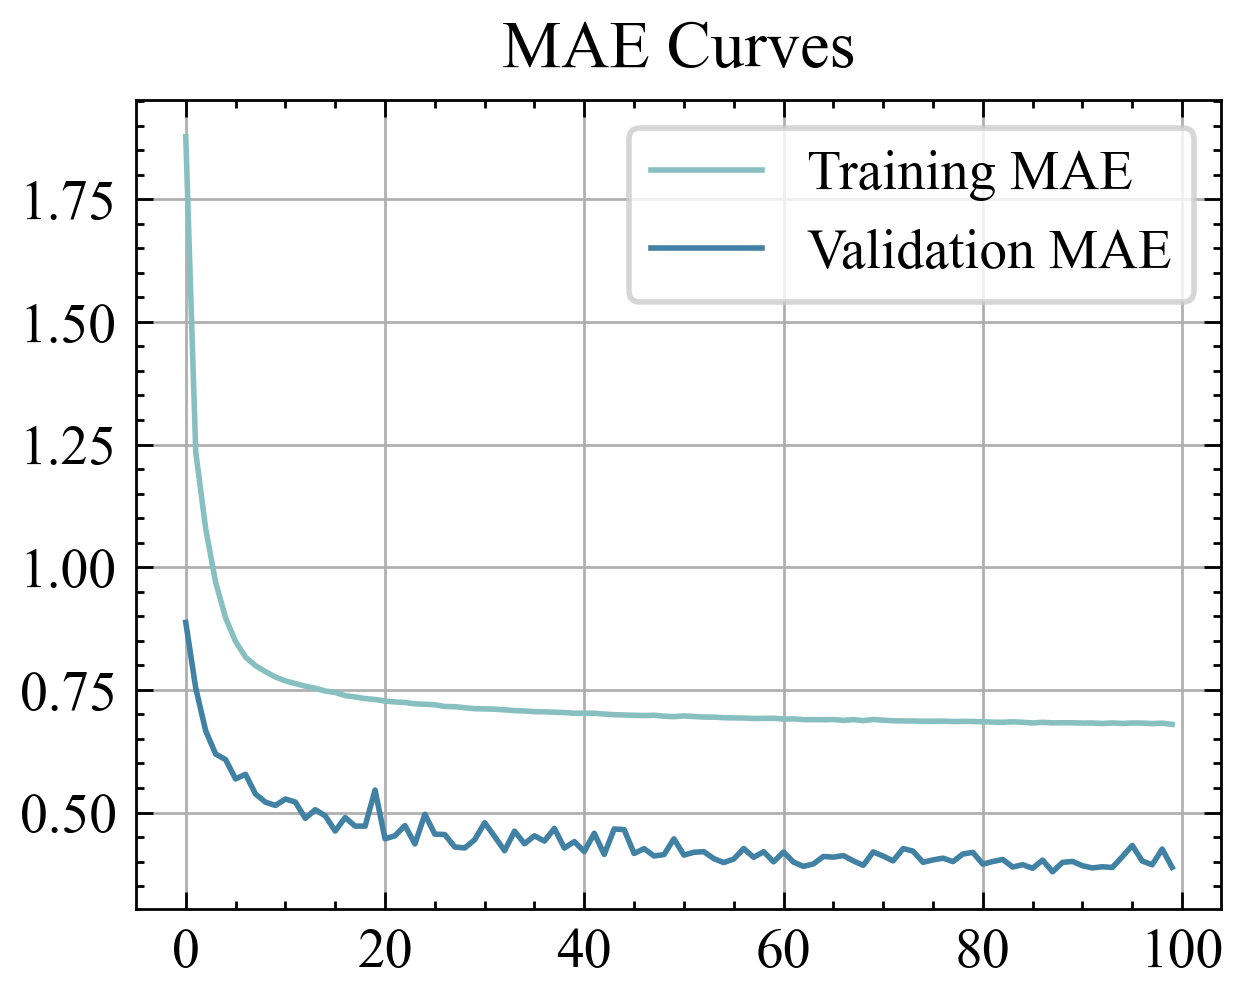

In [8]:
l=[]
with open('../Data/loss.csv','rt') as f: 
    cr = csv.reader(f)
    for row in cr:
        row = list(map(float, row))
        l.append(row) 
nl = np.array(l)
# print(nl)
color_table = ['#192947','#4081A4','#88C0C1','#B2D5C9']

import matplotlib.pyplot as plt
with plt.style.context(['science']):
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 
    plt.plot(nl[:,0],linewidth=1,color=color_table[2],label='Training MAE')
    plt.plot(nl[:,1],linewidth=1,color=color_table[1],label='Validation MAE')
    plt.grid()
    plt.title('MAE Curves')
    plt.legend()
    plt.show()
    # a = range(1,29,5)
    # labels = np.array(a)/2
    # plt.xticks(a,labels=labels)
    # plt.yticks(a,labels=labels)
    # plt.colorbar()

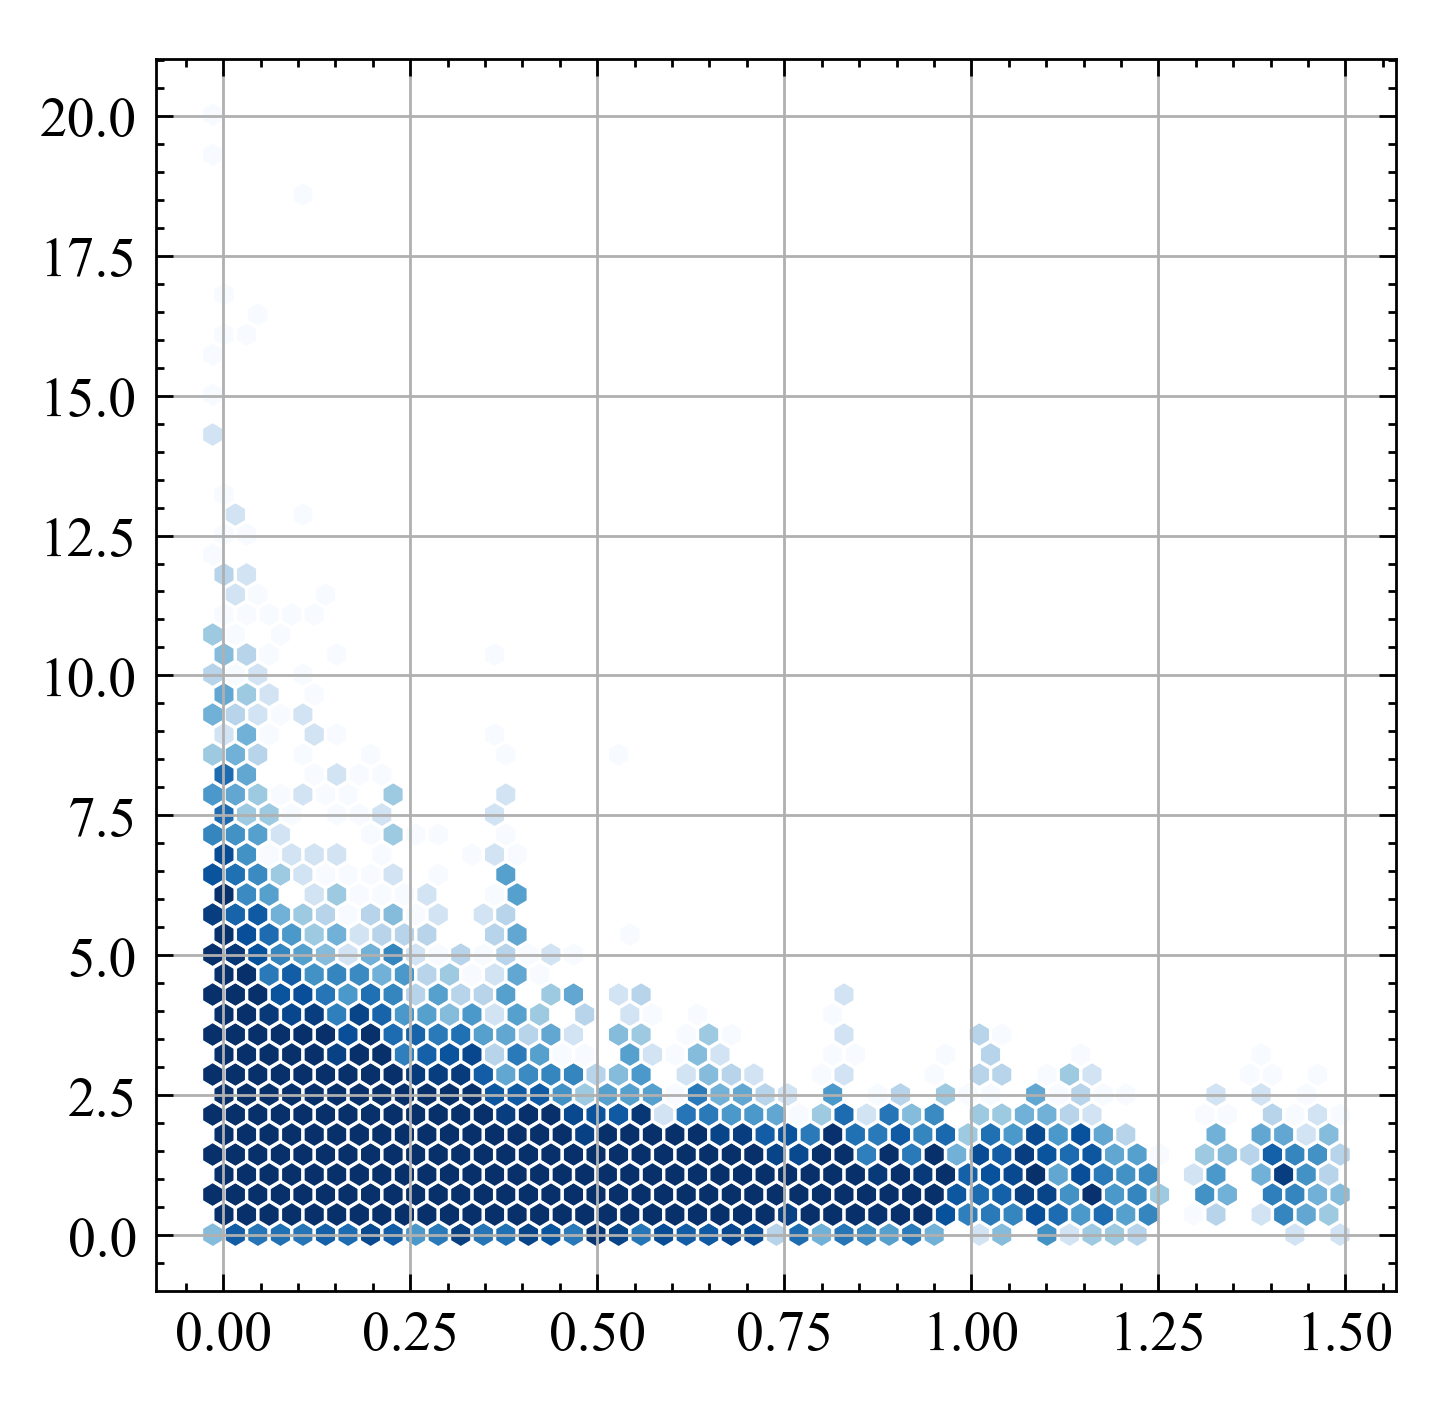

In [6]:
# 误差随压力分布密度图
import matplotlib.pyplot as plt
import scienceplots

x = []
y = []
for i in range(36300):
    pos_p = predict[i]
    truth_p = position[i]
    force_p = press[i]
    err = np.sqrt((pos_p[0]-truth_p[0])*(pos_p[0]-truth_p[0]) + (pos_p[1]-truth_p[1])*(pos_p[1]-truth_p[1]))
    x.append(force_p)
    y.append(err)

with plt.style.context(['science']):
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 
    plt.figure(figsize=(4,4))
    plt.hexbin(x, y, 
            #    extent=(0,1.5,0,1.5),
               bins='log',
               vmax=40, vmin=1,
               gridsize=50, cmap='Blues',alpha=1,
               edgecolor='white',linewidths=0.6,
               label = 'Reality')
    plt.grid()
plt.show()

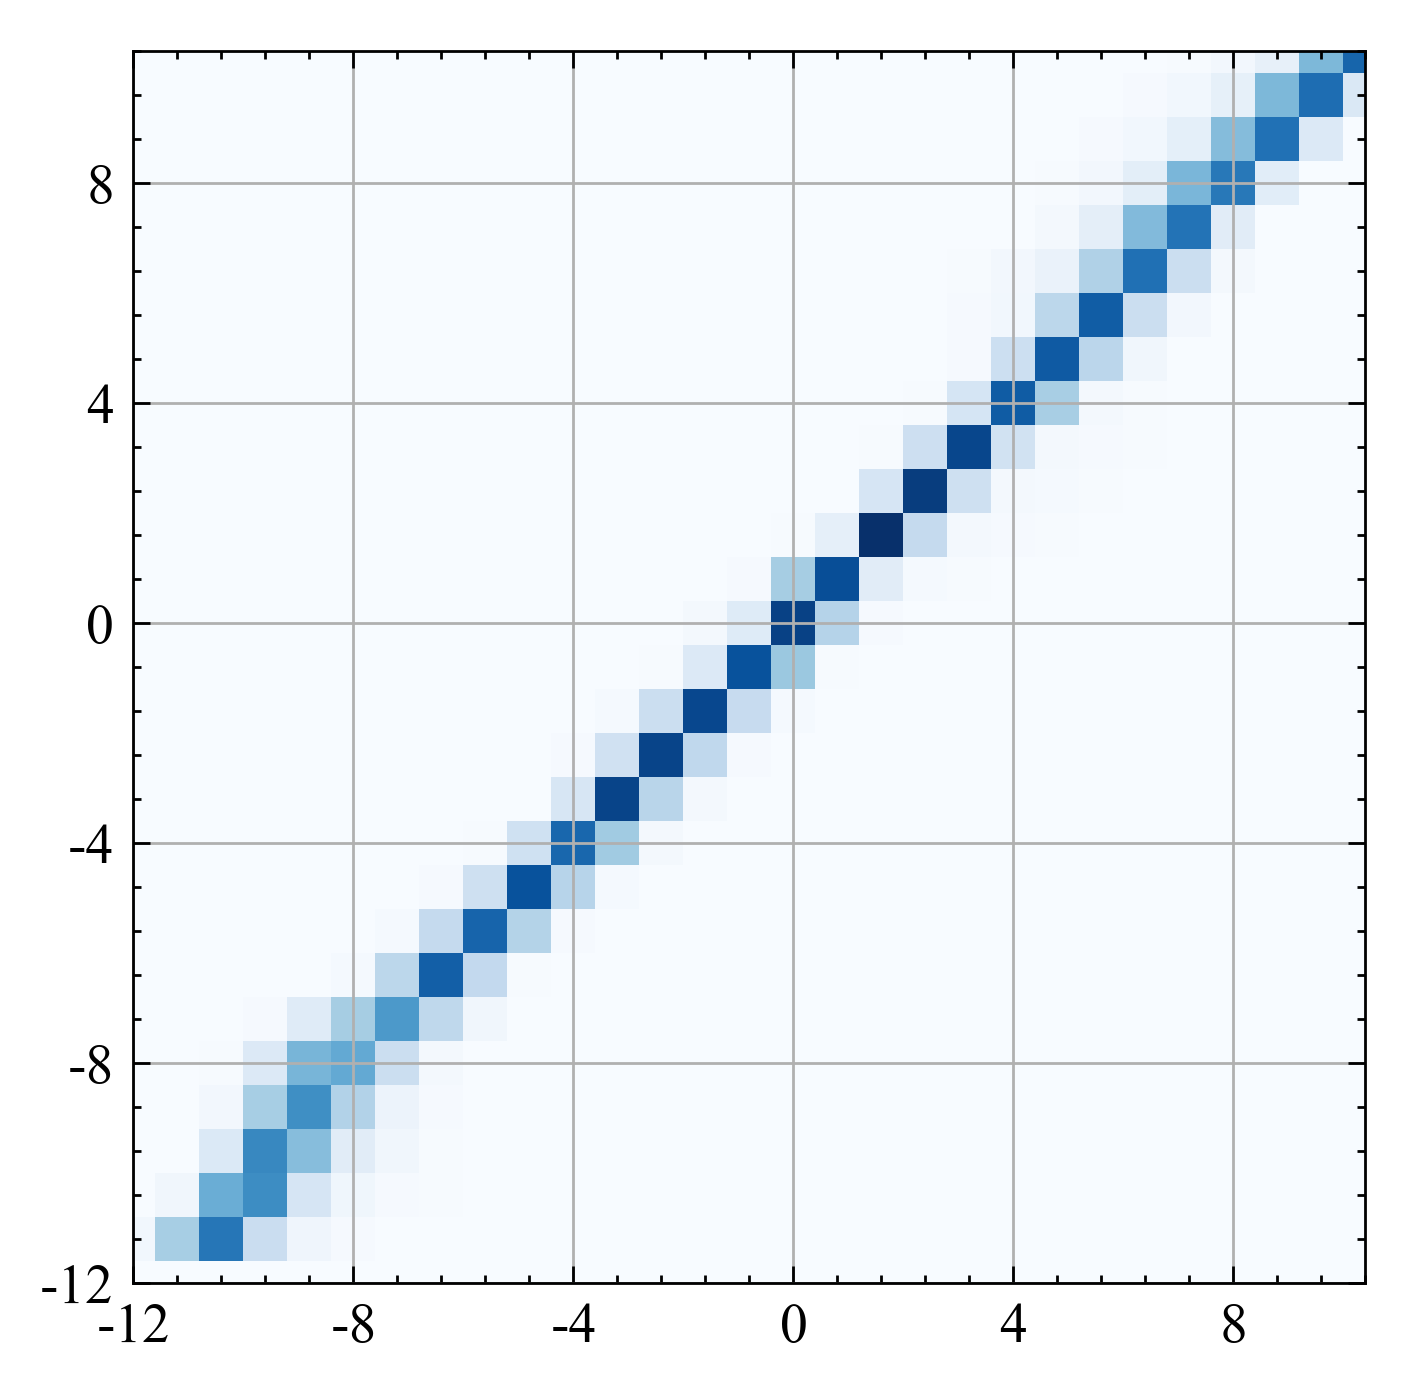

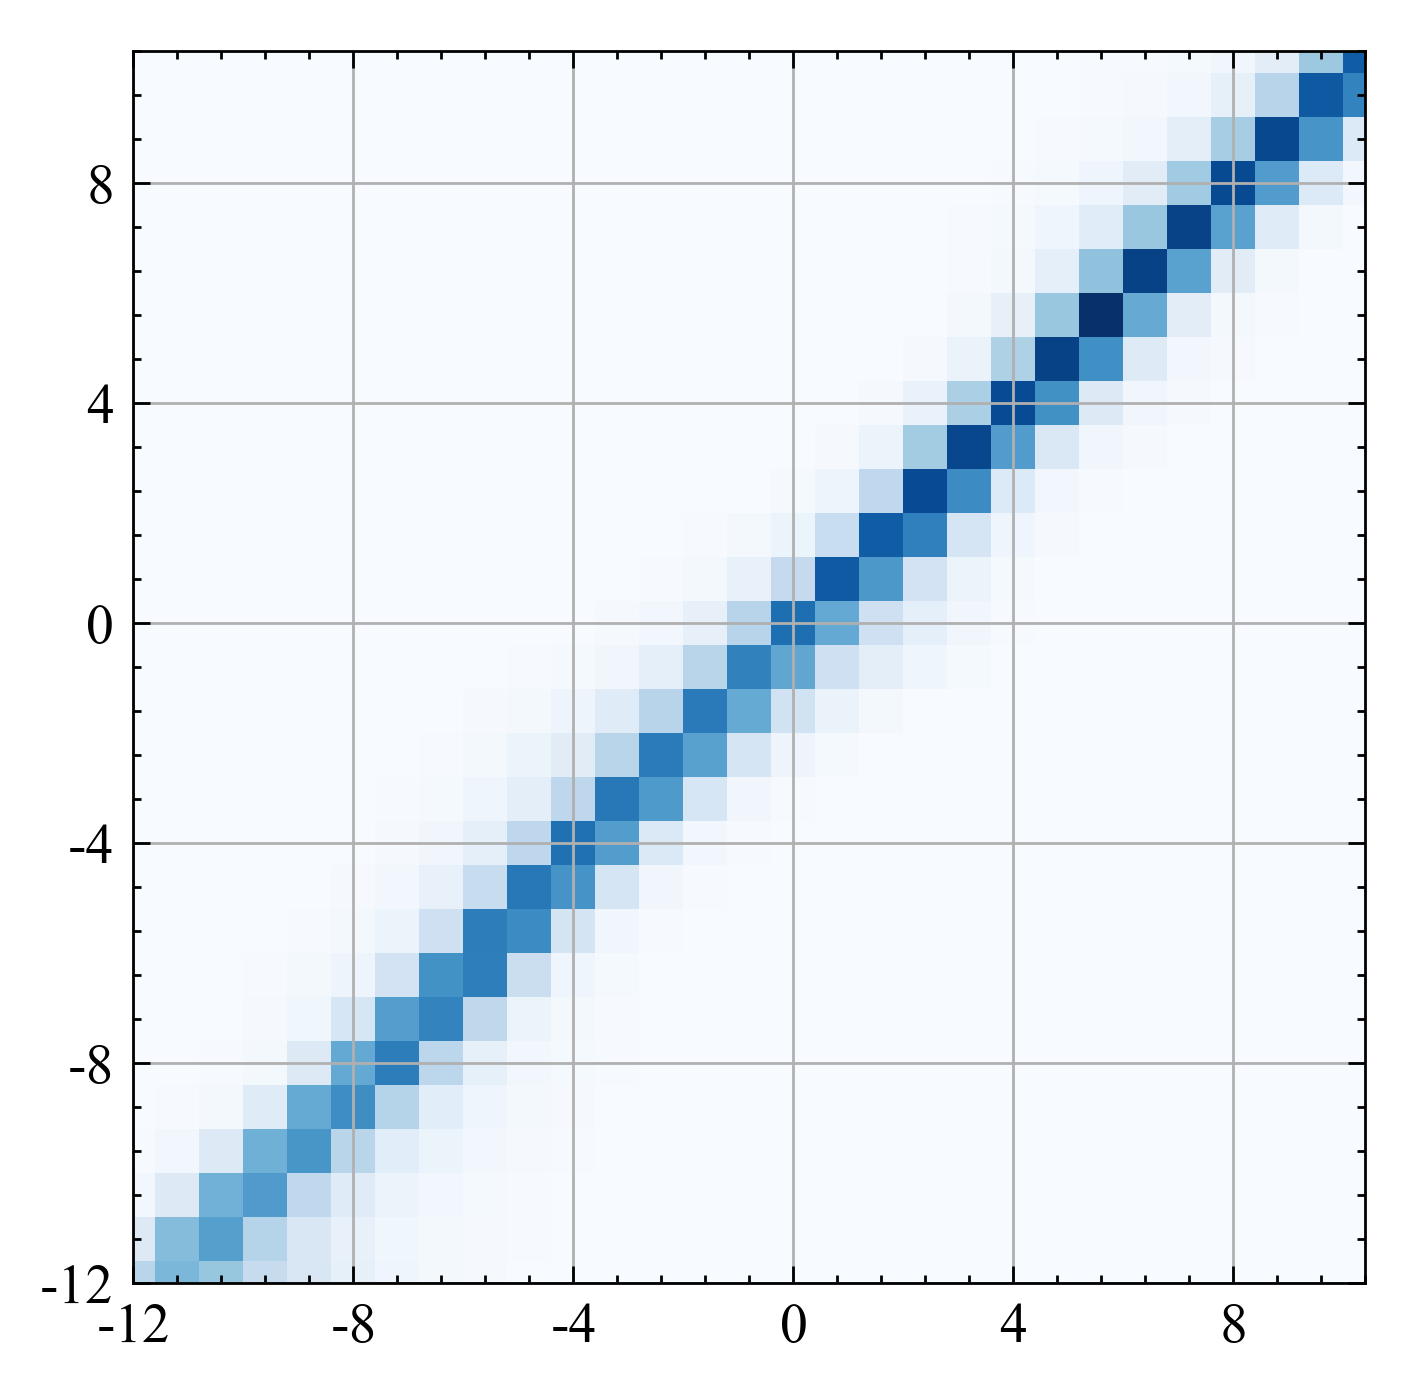

In [13]:
# 混淆矩阵
l = []
import csv
import scienceplots
import matplotlib.pyplot as plt

with open('../Data/xconn.csv','rt') as f: 
    cr = csv.reader(f)
    for row in cr:
       row = list(map(int, row))
       l.append(row) 
nl = np.array(l)

with plt.style.context(['science']):
    
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 
    plt.figure(figsize=(4,4))
    plt.imshow(nl,interpolation='nearest', cmap=plt.cm.Blues)
    a = range(0,32,5)
    labels = [-12,-8,-4,0,4,8,12]
    plt.xticks(a,labels=labels)
    plt.yticks(a,labels=labels)
    plt.xlim([0,28])
    plt.ylim([0,28])
    plt.grid()
    # plt.colorbar()

l= []
with open('../Data/yconn.csv','rt') as f: 
    cr = csv.reader(f)
    for row in cr:
       row = list(map(int, row))
       l.append(row) 
nl = np.array(l)
with plt.style.context(['science']):
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 
    plt.figure(figsize=(4,4))
    plt.imshow(nl,interpolation='nearest', cmap=plt.cm.Blues)
    a = range(0,32,5)
    labels = [-12,-8,-4,0,4,8,12]
    plt.xticks(a,labels=labels)
    plt.yticks(a,labels=labels)
    plt.xlim([0,28])
    plt.ylim([0,28])
    plt.grid()
    # plt.colorbar()
plt.show()

In [7]:
# predict-truth
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

font1  = {'family': 'SimSun',
'weight': 'normal',
'size': 10,
}
ref = np.swapaxes([np.linspace(0,1,1000),np.linspace(0,1,1000)] ,0,1)
predict = predict.reshape(36300)
with plt.style.context(['science']):
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 

    plt.figure(figsize=(4,4))
    plt.hexbin(press, predict, 
               extent=(0,1.5,0,1.5),
               bins='log',
               vmax=400, vmin=1,
               gridsize=50, cmap='Blues',alpha=1,
               edgecolor='white',linewidths=0.6,
               label = '实测值')
    plt.plot([0.1,1.4],[0.1,1.4],
             color = '#ff0000',label = '期望值',linestyle ='--',linewidth=1)
    plt.grid()  
    plt.legend(prop=font1)
    plt.xlabel('Truth/N')
    plt.ylabel('Predict/N')
plt.show()

ValueError: cannot reshape array of size 72600 into shape (36300,)

<Figure size 1400x1050 with 0 Axes>

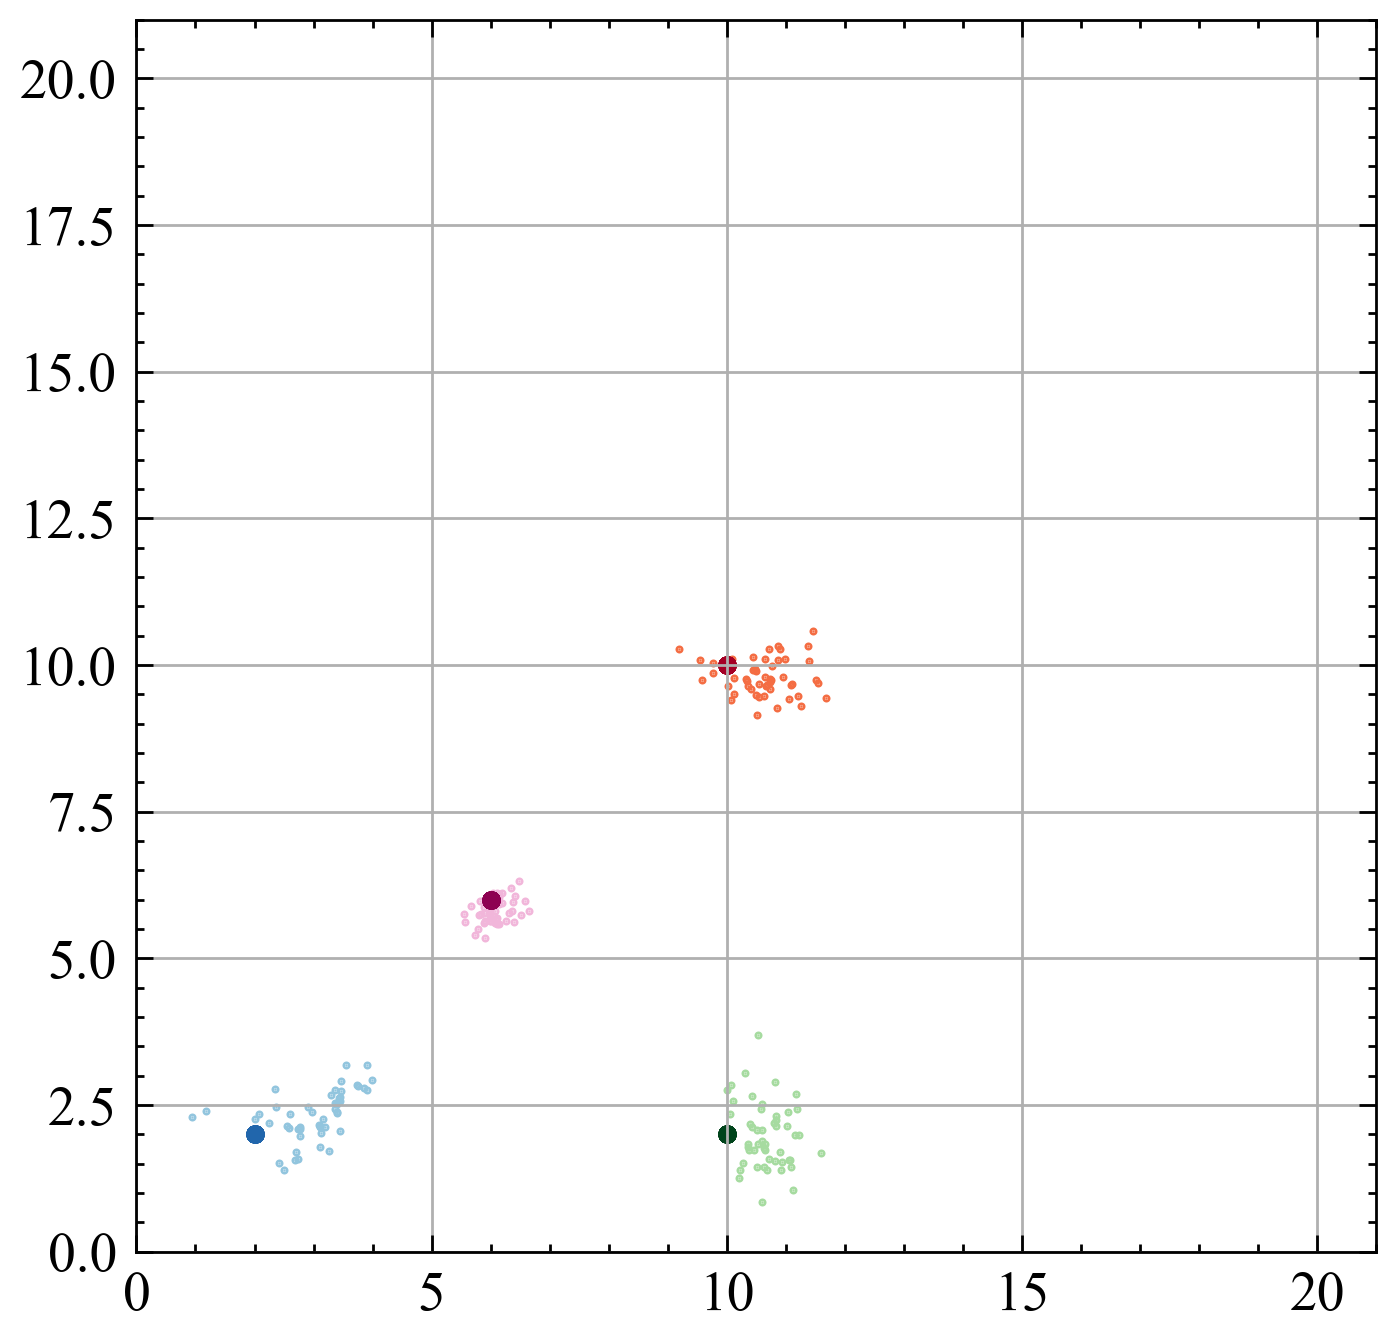

In [6]:
# 典型点预测
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

color_table2 = [['#2166ac','#92c5de'],['#a50026','#f46d43'],['#00441b','#a6dba0'],['#8e0152','#f1b6da']]
ps = [11*1+1,11*5+5,11*5+1,11*3+3]
with plt.style.context(['science']):
    plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
    plt.rcParams['savefig.dpi'] = 400 #图片像素
    plt.rcParams['figure.dpi'] = 400 #分辨率
    plt.rcParams["legend.frameon"] = True
    plt.rcParams['text.usetex'] = False
    plt.rc('font',family='Times New Roman') 
    plt.figure()
    fig, ax = plt.subplots(figsize=(4,4))  
    i=0 
    for p in ps:
        plt.scatter(predict[p*300+250:p*300+300,0],predict[p*300+250:p*300+300,1],s=0.2,alpha=1,color=color_table2[i][1])
        plt.scatter(position[p*300+200:p*300+250,0],position[p*300+200:p*300+250,1],s=5,color=color_table2[i][0])
        i+=1
        #print(position[p*50:p*50+50,0],position[p*50:p*50+50,1])
    plt.grid()
    plt.xlim(0,21)
    plt.ylim(0,21)
    # plt.xticks(range(0,15,2))
    # plt.yticks(range(0,15,2))
    plt.show()
